In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

[2021-11-07 10:35:01,276] {utils.py:141} INFO - NumExpr defaulting to 8 threads.
95.63492063492063

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       128
           1       0.92      0.99      0.96       124

    accuracy                           0.96       252
   macro avg       0.96      0.96      0.96       252
weighted avg       0.96      0.96      0.96       252



<AxesSubplot:>

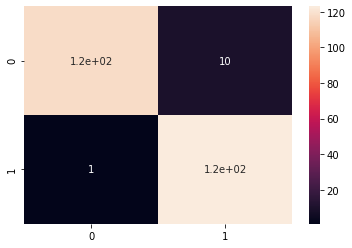

In [8]:
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200)
df2 = df1.sort_values(by='incident_date',ascending=False).tail(800)
df1_val = df1_val.drop(["incident_date"],axis=1)
df2 = df2.drop(["incident_date"],axis=1)   
    
    
df3 = df2.apply(LabelEncoder().fit_transform)
df3.head()

features = []
for col in df3.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df3[features]
y = df3[target]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

80.0

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       163
           1       0.48      0.78      0.59        37

    accuracy                           0.80       200
   macro avg       0.71      0.79      0.73       200
weighted avg       0.86      0.80      0.82       200



<AxesSubplot:>

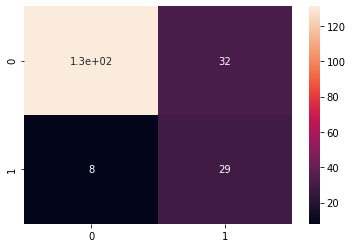

In [9]:
df3_val = df1_val.apply(LabelEncoder().fit_transform)
df3.head()

features = []
for col in df3_val.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df3_val[features]
y_val = df3_val[target]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

preds = rfc.predict(X_val)

score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [10]:
import pickle

In [11]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [12]:
loaded_model = pickle.load(open(filename, 'rb'))

80.0

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       163
           1       0.48      0.78      0.59        37

    accuracy                           0.80       200
   macro avg       0.71      0.79      0.73       200
weighted avg       0.86      0.80      0.82       200



<AxesSubplot:>

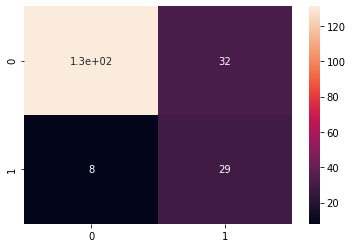

In [13]:
preds = loaded_model.predict(X_val)

score = loaded_model.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [14]:
preds

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0], dtype=int64)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder().appName("Spark_SQL_5_Save To Hive").enableHiveSupport().getOrCreate();
    spark.sparkContext().conf().set("spark.sql.warehouse.dir", "/user/hive/warehouse");
    spark.sparkContext().conf().set("hive.metastore.uris", "thrift://localhost:9083");

In [ ]:
dataframe = pd.read_sql("SELECT * FROM mintu.values__tmp__table__6", spark)

In [ ]:
preds = loaded_model.predict(dataframe)

In [ ]:
spark_df = spark.createDataFrame(preds)

In [ ]:
spark_df.createOrReplaceTempView("mytempTable") 

In [ ]:
spark.sql("create table mytable as select * from mytempTable");

In [ ]:
spark.sql("insert into table mytable select mytempTable.* from (select 1, 10) mytempTable")

In [ ]:
from datetime import datetime, timedelta

from airflow import DAG
from airflow.providers.papermill.operators.papermill import PapermillOperator

def hello():
    pass

def printt():
    pass


default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 0,
    'retry_delay': timedelta(minutes=1)
}

with DAG(
    dag_id='example_papermill_operator',
    default_args=default_args,
    schedule_interval='0 0 * * *',
    start_date=datetime(2021, 1, 1),
    template_searchpath='/usr/local/airflow/include',
    catchup=False
) as dag_1:

    notebook_task = PapermillOperator(
        task_id="run_example_notebook",
        input_nb="include/example_notebook.ipynb",
        output_nb="include/out-{{ execution_date }}.ipynb",
        parameters={"execution_date": "{{ execution_date }}"},
    )


![ARF](Airflow.png)